# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

## Подготовка данных

Импортируем необходимые библиотеки и прочитаем файл в переменную

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.utils import shuffle

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

Посмотрим общую информацию о файле

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Посмотрим первые и последние строки файла

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


При начальном просмотре выявлены следующие проблемы:
* Столбец RowNumber дублирует номера строк, можно удалить
* Столбцы CustomerId и Surname не играют роли в исследовании, можно удалить
* Названия столбцов необходимо привести к верблюжьему регистру
* Вероятно, не все типы столбцов имеют правильный тип

### Названия столбцов

Получим список с названиями столбцов

In [6]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

Удалим ненужные столбцы и приведем остальные названия к нижнему регистру

In [7]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.columns = df.columns.str.lower()
df.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

Добавим нижнее подчеркивание там, где это необходимо

In [8]:
columns_rename = {'creditscore':'credit_score', 'numofproducts':'num_of_products', 'hascrcard':'has_cr_card', 
                  'isactivemember':'is_active', 'estimatedsalary':'estimated_salary'}
df = df.rename(columns=columns_rename)
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active', 'estimated_salary',
       'exited'],
      dtype='object')

### Пропуски

Проверим пропуски в данных

In [9]:
df.isna().sum()

credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active             0
estimated_salary      0
exited                0
dtype: int64

#### Явные пропуски

Явные пропуски только в столбце tenure - сколько лет человек является клиентом банка  
Посмотрим внимательнее на этот столбец

In [10]:
df['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

In [11]:
100 * len(df[df['tenure'].isna()]) / df.shape[0]

9.09

Пропуски в 9% данных, это достаточно много, удалять нельзя, посмотрим внимательнее на данные с пропусками

In [12]:
df[df['tenure'].isna()].head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


Восстановить часть данных из другой информации не представляется возможным, попробуем заменить случайными значениями от 0 до 10 (по min и max)

In [14]:
df['tenure'] = df['tenure'].fillna(-1)


import random
df.loc[(df['tenure'] == -1), 'tenure'] = df['tenure'].apply(lambda v: int(random.random() * 10))

In [15]:
df['tenure'].describe()

count    10000.000000
mean         4.952000
std          2.901954
min          0.000000
25%          2.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: tenure, dtype: float64

#### Неявные пропуски

Попробуем оценить неявные пропуски в данных

In [16]:
df['credit_score'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: credit_score, dtype: float64

Значения от 350 до 850

In [17]:
df['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

Клиенты из трех стран, все ок

In [18]:
df['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

Неопределенных данных нет, столбец можно привести к типу bool

In [19]:
df['age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

От 18 до 92, ок

In [20]:
df['balance'].describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64

Ок

In [21]:
df['num_of_products'].describe()

count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: num_of_products, dtype: float64

Ок

In [22]:
df['has_cr_card'].value_counts()

1    7055
0    2945
Name: has_cr_card, dtype: int64

Два значения - к типу bool

In [23]:
df['is_active'].value_counts()

1    5151
0    4849
Name: is_active, dtype: int64

Два значения - к типу bool

In [24]:
df['estimated_salary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64

Не очень понятные данные, оставим как есть

In [25]:
df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

Два значения - к типу bool

### Типы данных

Преобразуем типы данных описанных выше столбцов

In [26]:
df.loc[(df['gender'] == 'Female'), 'gender'] = 0
df.loc[(df['gender'] == 'Male'), 'gender'] = 1
df['gender'] = df['gender'].astype(bool)
df['gender'].value_counts()

True     5457
False    4543
Name: gender, dtype: int64

In [27]:
df['has_cr_card'] = df['has_cr_card'].astype(bool)
df['has_cr_card'].value_counts()

True     7055
False    2945
Name: has_cr_card, dtype: int64

In [28]:
df['is_active'] = df['is_active'].astype(bool)
df['is_active'].value_counts()

True     5151
False    4849
Name: is_active, dtype: int64

In [29]:
df['exited'] = df['exited'].astype(bool)
df['exited'].value_counts()

False    7963
True     2037
Name: exited, dtype: int64

Проверим данные на дубликаты

In [30]:
df.duplicated().sum()

0

## Исследование задачи

### Подготовка к машинному обучению

Построим матрицу корреляции признаков

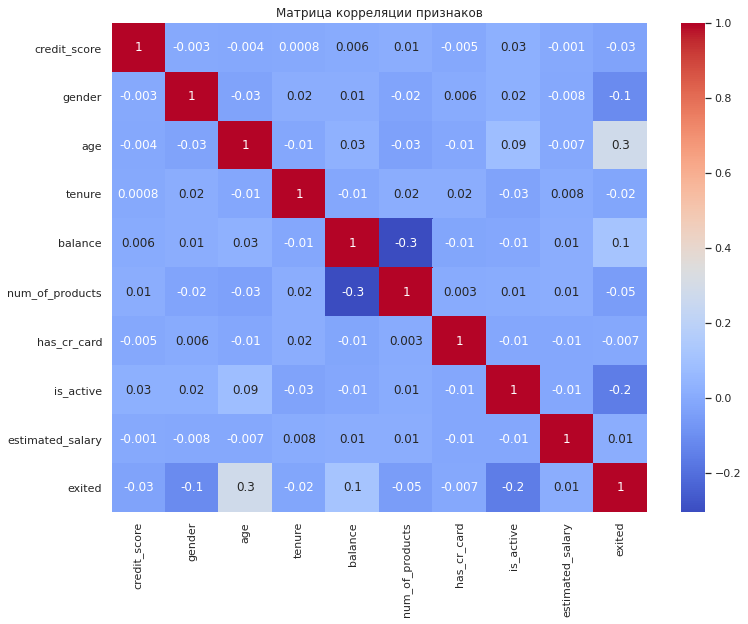

In [31]:
sns.set(rc = {'figure.figsize':(12,9)})
sns.heatmap(df.corr(), annot = True, fmt='.1g',  cmap='coolwarm')

plt.title("Матрица корреляции признаков")

plt.show()

Проведем кодирование OHE - One-Hot Encoding, избегая дамми-ловушку

In [32]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active,estimated_salary,exited,geography_Germany,geography_Spain
0,619,False,42,2.0,0.00,1,True,True,101348.88,True,0,0
1,608,False,41,1.0,83807.86,1,False,True,112542.58,False,0,1
2,502,False,42,8.0,159660.80,3,True,False,113931.57,True,0,0
3,699,False,39,1.0,0.00,2,False,False,93826.63,False,0,0
4,850,False,43,2.0,125510.82,1,True,True,79084.10,False,0,1


Масштабируем данные методом стандартизации данных с использованием StandardScaler

In [33]:
pd.options.mode.chained_assignment = None #выдавало алерт о том, что работаем с "отрезом" данных

scaler = StandardScaler()
data = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
scaler.fit(df[data])
df[data] = scaler.transform(df[data])
df.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active,estimated_salary,exited,geography_Germany,geography_Spain
0,-0.326221,False,0.293517,-1.017296,-1.225848,-0.911583,True,True,0.021886,True,0,0
1,-0.440036,False,0.198164,-1.361909,0.117350,-0.911583,False,True,0.216534,False,0,1
2,-1.536794,False,0.293517,1.050379,1.333053,2.527057,True,False,0.240687,True,0,0
3,0.501521,False,0.007457,-1.361909,-1.225848,0.807737,False,False,-0.108918,False,0,0
4,2.063884,False,0.388871,-1.017296,0.785728,-0.911583,True,True,-0.365276,False,0,1


Разделим датасет на три выборки в соотношении 3:1:1
* train - обучение модели
* valid - выбор лучшего алгоритма и гиперпараметров
* test - финальный тест лучшей модели

In [34]:
features = df.drop(['exited'], axis=1)
target = df['exited']

features_train, features_x, target_train, target_x = train_test_split(
    features, target, train_size=0.6, test_size=0.4, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_x, target_x, test_size=0.5, random_state=12345)

Масштабируем данные методом стандартизации данных с использованием StandardScaler

### Машинное обучение

#### DecisionTreeClassifier

Исследуем модель "дерево решений", проверим глубину дерева от 1 до 20

In [36]:
best_model = None
best_f1 = 0
best_roc = 0
best_depth = 0

In [37]:
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    
    model.fit(features_train, target_train)
    
    predictions_valid = model.predict(features_valid)
    
    f1_valid = f1_score(target_valid, predictions_valid)
    
    if f1_valid > best_f1:
        best_model = model
        best_f1 = f1_valid
        best_roc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])
        best_depth = depth

In [38]:
print("F1 лучшей модели", best_f1, "\nROC лучшей модели", best_roc, "\nГлубина дерева:", best_depth)

F1 лучшей модели 0.5261538461538461 
ROC лучшей модели 0.8363195222097799 
Глубина дерева: 6


#### RandomForestClassifier

Исследуем модель "случайный лес", проверим количество деревьев и глубину дерева от 1 до 20

In [39]:
best_model = None
best_f1 = 0
best_roc = 0
best_depth=0
best_est = 0

In [40]:
for est in range(1, 21):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        
        model.fit(features_train, target_train)
        
        predictions_valid = model.predict(features_valid) 
        
        f1_valid = f1_score(target_valid, predictions_valid)
        
        if f1_valid > best_f1:
            best_model = model
            best_f1 = f1_valid
            best_roc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])
            best_depth = depth
            best_est = est

In [41]:
print("F1 лучшей модели", best_f1, "\nROC лучшей модели", best_roc, 
      "\nГлубина дерева:", best_depth, "\nКоличество деревьев:", best_est)

F1 лучшей модели 0.5557163531114326 
ROC лучшей модели 0.824117672631549 
Глубина дерева: 13 
Количество деревьев: 9


#### LogisticRegression

Исследуем модель "логистическая регрессия"

In [42]:
model = LogisticRegression(random_state=12345, solver='liblinear')

model.fit(features_train, target_train)

predictions_valid = model.predict(features_valid) 

f1_valid = f1_score(target_valid, predictions_valid)
roc_valid = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])

In [43]:
print("F1 модели", f1_valid, "\nROC модели", roc_valid)

F1 модели 0.2743055555555555 
ROC модели 0.7387444514901711


Лучший результат дает модель RandomForestClassifier:
* F1 лучшей модели 0.56071964017991 
* ROC лучшей модели 0.8474105455041516 
* Глубина дерева: 12 
* Количество деревьев: 18

## Борьба с дисбалансом

Проверим баланс классов

In [44]:
target_train.value_counts(normalize = 1)

False    0.800667
True     0.199333
Name: exited, dtype: float64

In [45]:
target_valid.value_counts(normalize = 1)

False    0.7885
True     0.2115
Name: exited, dtype: float64

In [46]:
target_test.value_counts(normalize = 1)

False    0.791
True     0.209
Name: exited, dtype: float64

У выборок наблюдается значительный дисбаланс классов: 80% ответы False и 20% ответы True

Попробуем улучшить модель различными способами борьбы с дисбалансом

### Взвешивание классов

In [47]:
best_model = None
best_f1 = 0
best_roc = 0
best_depth=0
best_est = 0

In [48]:
for est in range(1, 21):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        
        model.fit(features_train, target_train)
        
        predictions_valid = model.predict(features_valid) 
        
        f1_valid = f1_score(target_valid, predictions_valid)

        if f1_valid > best_f1:
            best_model = model
            best_f1 = f1_valid
            best_roc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])
            best_depth = depth
            best_est = est

In [49]:
print("F1 лучшей модели", best_f1, "\nROC лучшей модели", best_roc,
      "\nГлубина дерева:", best_depth, "\nКоличество деревьев:", best_est)

F1 лучшей модели 0.6128680479825517 
ROC лучшей модели 0.8457053297175263 
Глубина дерева: 8 
Количество деревьев: 19


Удалось добиться улучшения модели

### Увеличение выборки

Попробуем улучшить модель методом увеличения выборки

In [50]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [51]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [52]:
best_model = None
best_f1 = 0
best_roc = 0
best_depth=0
best_est = 0

In [53]:
for est in range(1, 21):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        
        model.fit(features_upsampled, target_upsampled)
        
        predictions_valid = model.predict(features_valid) 
        
        f1_valid = f1_score(target_valid, predictions_valid)
        
        if f1_valid > best_f1:
            best_model = model
            best_f1 = f1_valid
            best_roc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])
            best_depth = depth
            best_est = est

In [54]:
print("F1 лучшей модели", best_f1, "\nROC лучшей модели", best_roc,
      "\nГлубина дерева:", best_depth, "\nКоличество деревьев:", best_est)

F1 лучшей модели 0.6107226107226107 
ROC лучшей модели 0.8444063675380881 
Глубина дерева: 12 
Количество деревьев: 16


Также удалось добиться улучшения модели, но у балансировки классов результат немного выше

### Уменьшение выборки

In [55]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [56]:
features_upsampled, target_upsampled = downsample(features_train, target_train, 0.1)

In [57]:
best_model = None
best_f1 = 0
best_roc = 0
best_depth=0
best_est = 0

In [58]:
for est in range(1, 21):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        
        model.fit(features_upsampled, target_upsampled)
        
        predictions_valid = model.predict(features_valid) 
        
        f1_valid = f1_score(target_valid, predictions_valid)
        
        if f1_valid > best_f1:
            best_model = model
            best_f1 = f1_valid
            best_roc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])
            best_depth = depth
            best_est = est

In [59]:
print("F1 лучшей модели", best_f1, "\nROC лучшей модели", best_roc,
      "\nГлубина дерева:", best_depth, "\nКоличество деревьев:", best_est)

F1 лучшей модели 0.5125208681135226 
ROC лучшей модели 0.7352358294694268 
Глубина дерева: 14 
Количество деревьев: 2


При использовании этого способа модель ухудшилась

Таким образом, лучший результат (F1=0.6095, ROC=0.8485) дает случайное дерево с балансировкой классов и следующими гиперпараметрами:
* Глубина дерева: 9 
* Количество деревьев: 19

## Тестирование модели

Проведем тестирование модели с установленными параметрами

In [60]:
model = RandomForestClassifier(random_state=12345, n_estimators=19, max_depth=9, class_weight='balanced')
        
model.fit(features_train, target_train)
        
predictions_test = model.predict(features_test) 

roc_auc_test = roc_auc_score(target_test, model.predict_proba(features_test)[:,1])
f1_test = f1_score(target_test, predictions_test)

print("F1 модели", f1_test, "\nROC модели", roc_auc_test)

F1 модели 0.6157354618015963 
ROC модели 0.8493851281461899


Построим ROC-кривую

In [61]:
probabilities_test = model.predict_proba(features_test)

fpr, tpr, thresholds = roc_curve(target_test, probabilities_test[:, 1]) 

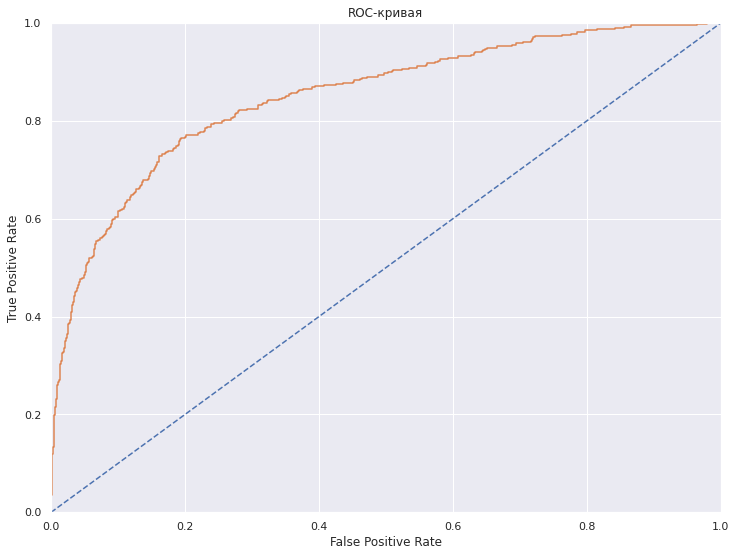

In [62]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [63]:
feature_results = pd.DataFrame({'feature': list(features_test.columns), 
                                'importance': model.feature_importances_})

feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results

,feature,importance
0,age,0.342077
1,num_of_products,0.187529
2,balance,0.110331
3,credit_score,0.077301
4,estimated_salary,0.074222
5,is_active,0.063345
6,geography_Germany,0.053018
7,tenure,0.043245
8,gender,0.027971
9,has_cr_card,0.012357


Text(0.5, 1.0, 'Feature Importances from Random Forest')

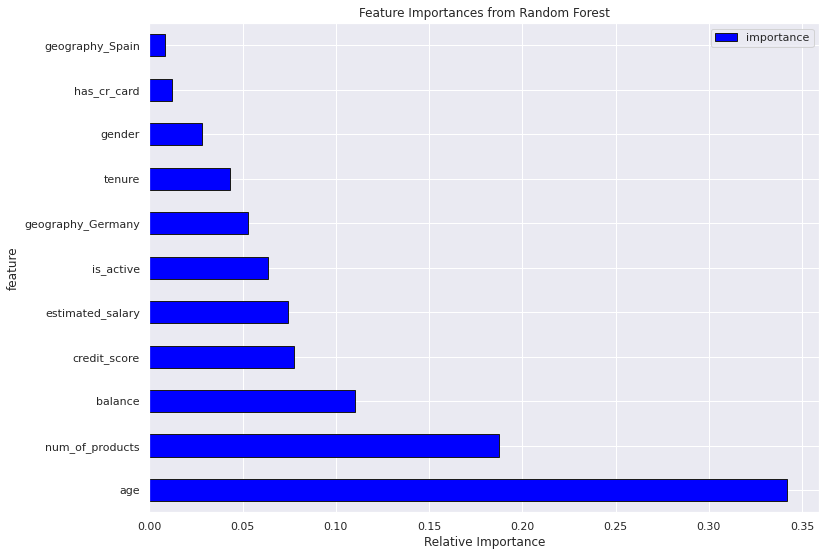

In [64]:
feature_results.plot(x = 'feature', y = 'importance', edgecolor = 'k', kind='barh', color = 'blue')

plt.xlabel('Relative Importance')

plt.title('Feature Importances from Random Forest')

**Вывод**  

При выполнении задачи были изучены и подготовлены данные (устранение пропусков, приведение к подходящим типам данных,  кодирование и масштабирование), исследованы три модели машинного обучения - решающее дерево, случайное дерево и логистическая регрессия

Лучшей моделью признано случайное дерево с балансировкой классов, установлены наилучшие гиперпараметры: глубина дерева 9, количество деревьев 19

На валидационной выборке при использовании этой модели удалось достичь значений метрик F1=0.6095 и ROC=0.8485

На тестовой выборке удалось достичь значений метрик F1=0.6186 и ROC=0.8452